In [1]:
### Import needed modules ###
import torch
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
tkwargs = {"device": torch.device("cuda" if torch.cuda.is_available() else "cpu"), "dtype": torch.double}
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import functools
from getdist import plots,MCSamples,loadMCSamples
from MCMCFunctions import *
from TestLikelihoods import *
from JaxFBGP import *
from JaxNS import *
from JaxACQ import *
from IntegratorFunctions import *
from scipy.stats import qmc

In [2]:
# Define other Bayop Parameters and settings ###
ndim = 1
ext_loglike = True
loglike = gaussian
nested_sampler = 'jax'
max_steps = 200
acq_goal = 10000000 #1e-1
noise = 1e-8
nstart = 4 if ndim < 2 else 8 if ndim > 4 else 8
batch_size = 2
nested_sample_every = 1
gpfit_every = 1
random_seed = 1000
interp_logp = True
gp_train_every = 1
save_plot = False
show_plot = True

print(f"Sampling {str(loglike)} function using {nstart} sobol samples to a maximum of {max_steps} steps with {batch_size} samples/step (maximum of {batch_size*max_steps} samples)")
print(f"Samples have a noise of {noise}, precision goal is {acq_goal}")
#print(f"{convergence_trials_max} convergence trials will be performed and {explore_trials_max} exploration trials before convergence is assumed")

Sampling <function gaussian at 0x32dc02de0> function using 4 sobol samples to a maximum of 200 steps with 2 samples/step (maximum of 400 samples)
Samples have a noise of 1e-08, precision goal is 10000000


In [3]:
### Set parameters based on these input settings ###
test_fnc_param_bounds = {'gaussian': [[[0, 1]], True], #
                         'gaussian_ring': [[[-1, 1]], True], 
                         'eggbox': [[[0, 1]], True], 
                         'banana': [[-1, 1], [-1, 2]], 
                         'himmelblau': [[[-6, 6]], True], 
                         'ackley': [[[-4, 4]], True]}

fnct_bounds = test_fnc_param_bounds[str(loglike.__name__)]

param_list = []
for i in range(1, ndim+1):
    param_list.append(f"x{i}")

if fnct_bounds[1] == True:
    fnct_bounds = fnct_bounds[0]*len(param_list) 

param_bounds = fnct_bounds
ndim = len(param_list)
print("Number of Dimensions: ", len(param_list))
print(param_list)
print(param_bounds)

bounds = np.array(param_bounds) if param_bounds is not None else np.array(len(param_list)*[[0,1]])
np_bounds = np.array(param_bounds)
bounds_dict = dict(zip(param_list, bounds))
logp = functools.partial(ext_logp_np, loglike=loglike, interp_logp=interp_logp, np_bounds=np_bounds)

Number of Dimensions:  1
['x1']
[[0, 1]]


In [4]:
if ndim == 2:
    plot_resolution = 1000
    x = np.linspace(0,1, plot_resolution)
    y = np.linspace(0,1, plot_resolution)
    xx, yy = np.meshgrid(x, y)
    if BOTORCH_FLAG:
        grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, **tkwargs)
        z = torch.exp(logp(grid).reshape(plot_resolution, plot_resolution))
        
    if JAX_FLAG:
        grid = np.vstack([xx.ravel(), yy.ravel()]).T
        z = np.exp(logp(grid).reshape(plot_resolution, plot_resolution))
        
    x = np.linspace(0,1, plot_resolution)
    y = np.full_like(x, 0)
    xx_x, yy_x = np.meshgrid(x, y)
    if BOTORCH_FLAG:
        grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, **tkwargs)
        z_x = torch.exp(logp(grid).reshape(plot_resolution, plot_resolution))
    if JAX_FLAG:
        grid = np.vstack([xx.ravel(), yy.ravel()]).T
        z_x = np.exp(logp(grid).reshape(plot_resolution, plot_resolution))
    print(z.shape)
    
    plt.figure()
    plt.contour(xx, yy, z)
    print(abs(z).min())
    plt.show()
    
    plt.figure()
    plt.plot(xx_x, yy_x, z_x)
    plt.show()

In [5]:
prior_fac = calc_prior_fac(bounds)
print("Prior volume factor: ", prior_fac)

logz_dy, logzerr_dy = dynesty_true_integral(bounds, ndim, acq_goal*(1e-1), logp, prior_fac)
if ndim < 3:
    logz_dbl, logzerr_dbl = dblquad_true_integral(bounds=param_bounds, prior_fac=prior_fac, logp=logp)
### Get analytic log(z) ###
analytic_integrals = {'gaussian': [0.250663, 0.250663**2, 0.250663**3, 0.250663**4, 0.250663**5, 0.250663**6, 0.250663**7, 0.250663**8, 0.250663**9, 0.250663**10, 0.250663**11, 0.250663**12,  0.250663**13, 0.250663**14, 0.250663**15, 0.250663**16, 0.250663**17, 0.250663**18, 0.250663**19, 0.250663**20], 'gaussian_ring': [0, 0.503987, 0], 'eggbox': [0, 6.57082e+9, 0], 'ackley': [0, np.exp(6.404064441895287)], 'banana': [0, 0.2417], 'himmelblau': [0, np.exp(0.9923)]}
logz_truth = np.log(analytic_integrals[str(loglike.__name__)][ndim-1])
###########################
print(f"Analytic LogZ Value = {logz_truth}")
dy_abs_err = np.abs(logz_truth - logz_dy)
print(f"Dynesty absolute error {dy_abs_err}")
if dy_abs_err < np.abs(logzerr_dy):
    print("Dynesty Error less than uncertainty range")
if ndim < 3:
    dbqd_abs_err = np.abs(logz_truth - logz_dbl)
    print(f"Double Quad absolute error {dbqd_abs_err}")
    if dbqd_abs_err < np.abs(logzerr_dbl):
        print("Dblquad error less than uncertainty range")

Prior volume factor:  0.0


10602it [00:08, 1240.47it/s, +1000 | bound: 8 | nc: 1 | ncall: 48364 | eff(%): 24.495 | loglstar:   -inf < -0.000 <    inf | logz: -1.385 +/-  0.030 | dlogz:  0.000 >  0.000]
INFO:[INT UTILS]:Logz from Dynesty = -1.3854737383450284 +- 0.029814262327671724 with 11602 samples
INFO:[INT UTILS]:LogZ from direct integration = -1.383647133092681 +- 8.668325659418051e-10 with 63 samples


Analytic LogZ Value = -1.3836458714669666
Dynesty absolute error 0.0018278668780618013
Dynesty Error less than uncertainty range
Double Quad absolute error 1.2616257143438503e-06


In [6]:
### Acquire Sobol Samples ###
np.random.seed(10004118) # fixed for reproducibility
train_X = qmc.Sobol(ndim, scramble=True).random(nstart)
train_Y = logp(train_X)

In [7]:
#Train_x must be normalised between [1, 0] before being parsed to GP
FBGP = saas_fbgp(train_X, train_Y, noise)
rng_key, _ = random.split(random.PRNGKey(random_seed), 2)
FBGP.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 1155.79it/s, 7 steps of size 8.41e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 2.08s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     27.64     41.99      8.69      0.19     87.11     33.26      0.99
        kernel_length[0]      0.40      0.17      0.42      0.16      0.64     18.14      0.99
            kernel_tausq     10.37     36.92      0.78      0.03     15.88     31.60      1.01
              kernel_var      9.13      5.51      7.84      1.06     17.34     24.04      0.98

Number of divergences: 0


Estimated precision on integral:  1 < 10000000


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 1014.36it/s, 3 steps of size 9.45e-01. acc. prob=0.93]


MCMC took 1.5363 s
2
Py-Bobyqa took 0.9382 s
New Points:  [[0.42293024]
 [0.50746206]]
Convergence Check:  1.3713204418624076 
 Pre-Var:  1.388163960830595 
 Post-Var:  0.016843518968187213


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 1315.39it/s, 7 steps of size 6.21e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.05s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     19.33     42.11      4.71      0.39     26.23     47.91      0.99
        kernel_length[0]      0.50      0.16      0.47      0.26      0.64    100.61      0.99
            kernel_tausq      1.87      2.79      0.68      0.03      4.26     38.65      0.98
              kernel_var     16.56      8.61     16.06      5.56     29.54     40.56      0.97

Number of divergences: 0


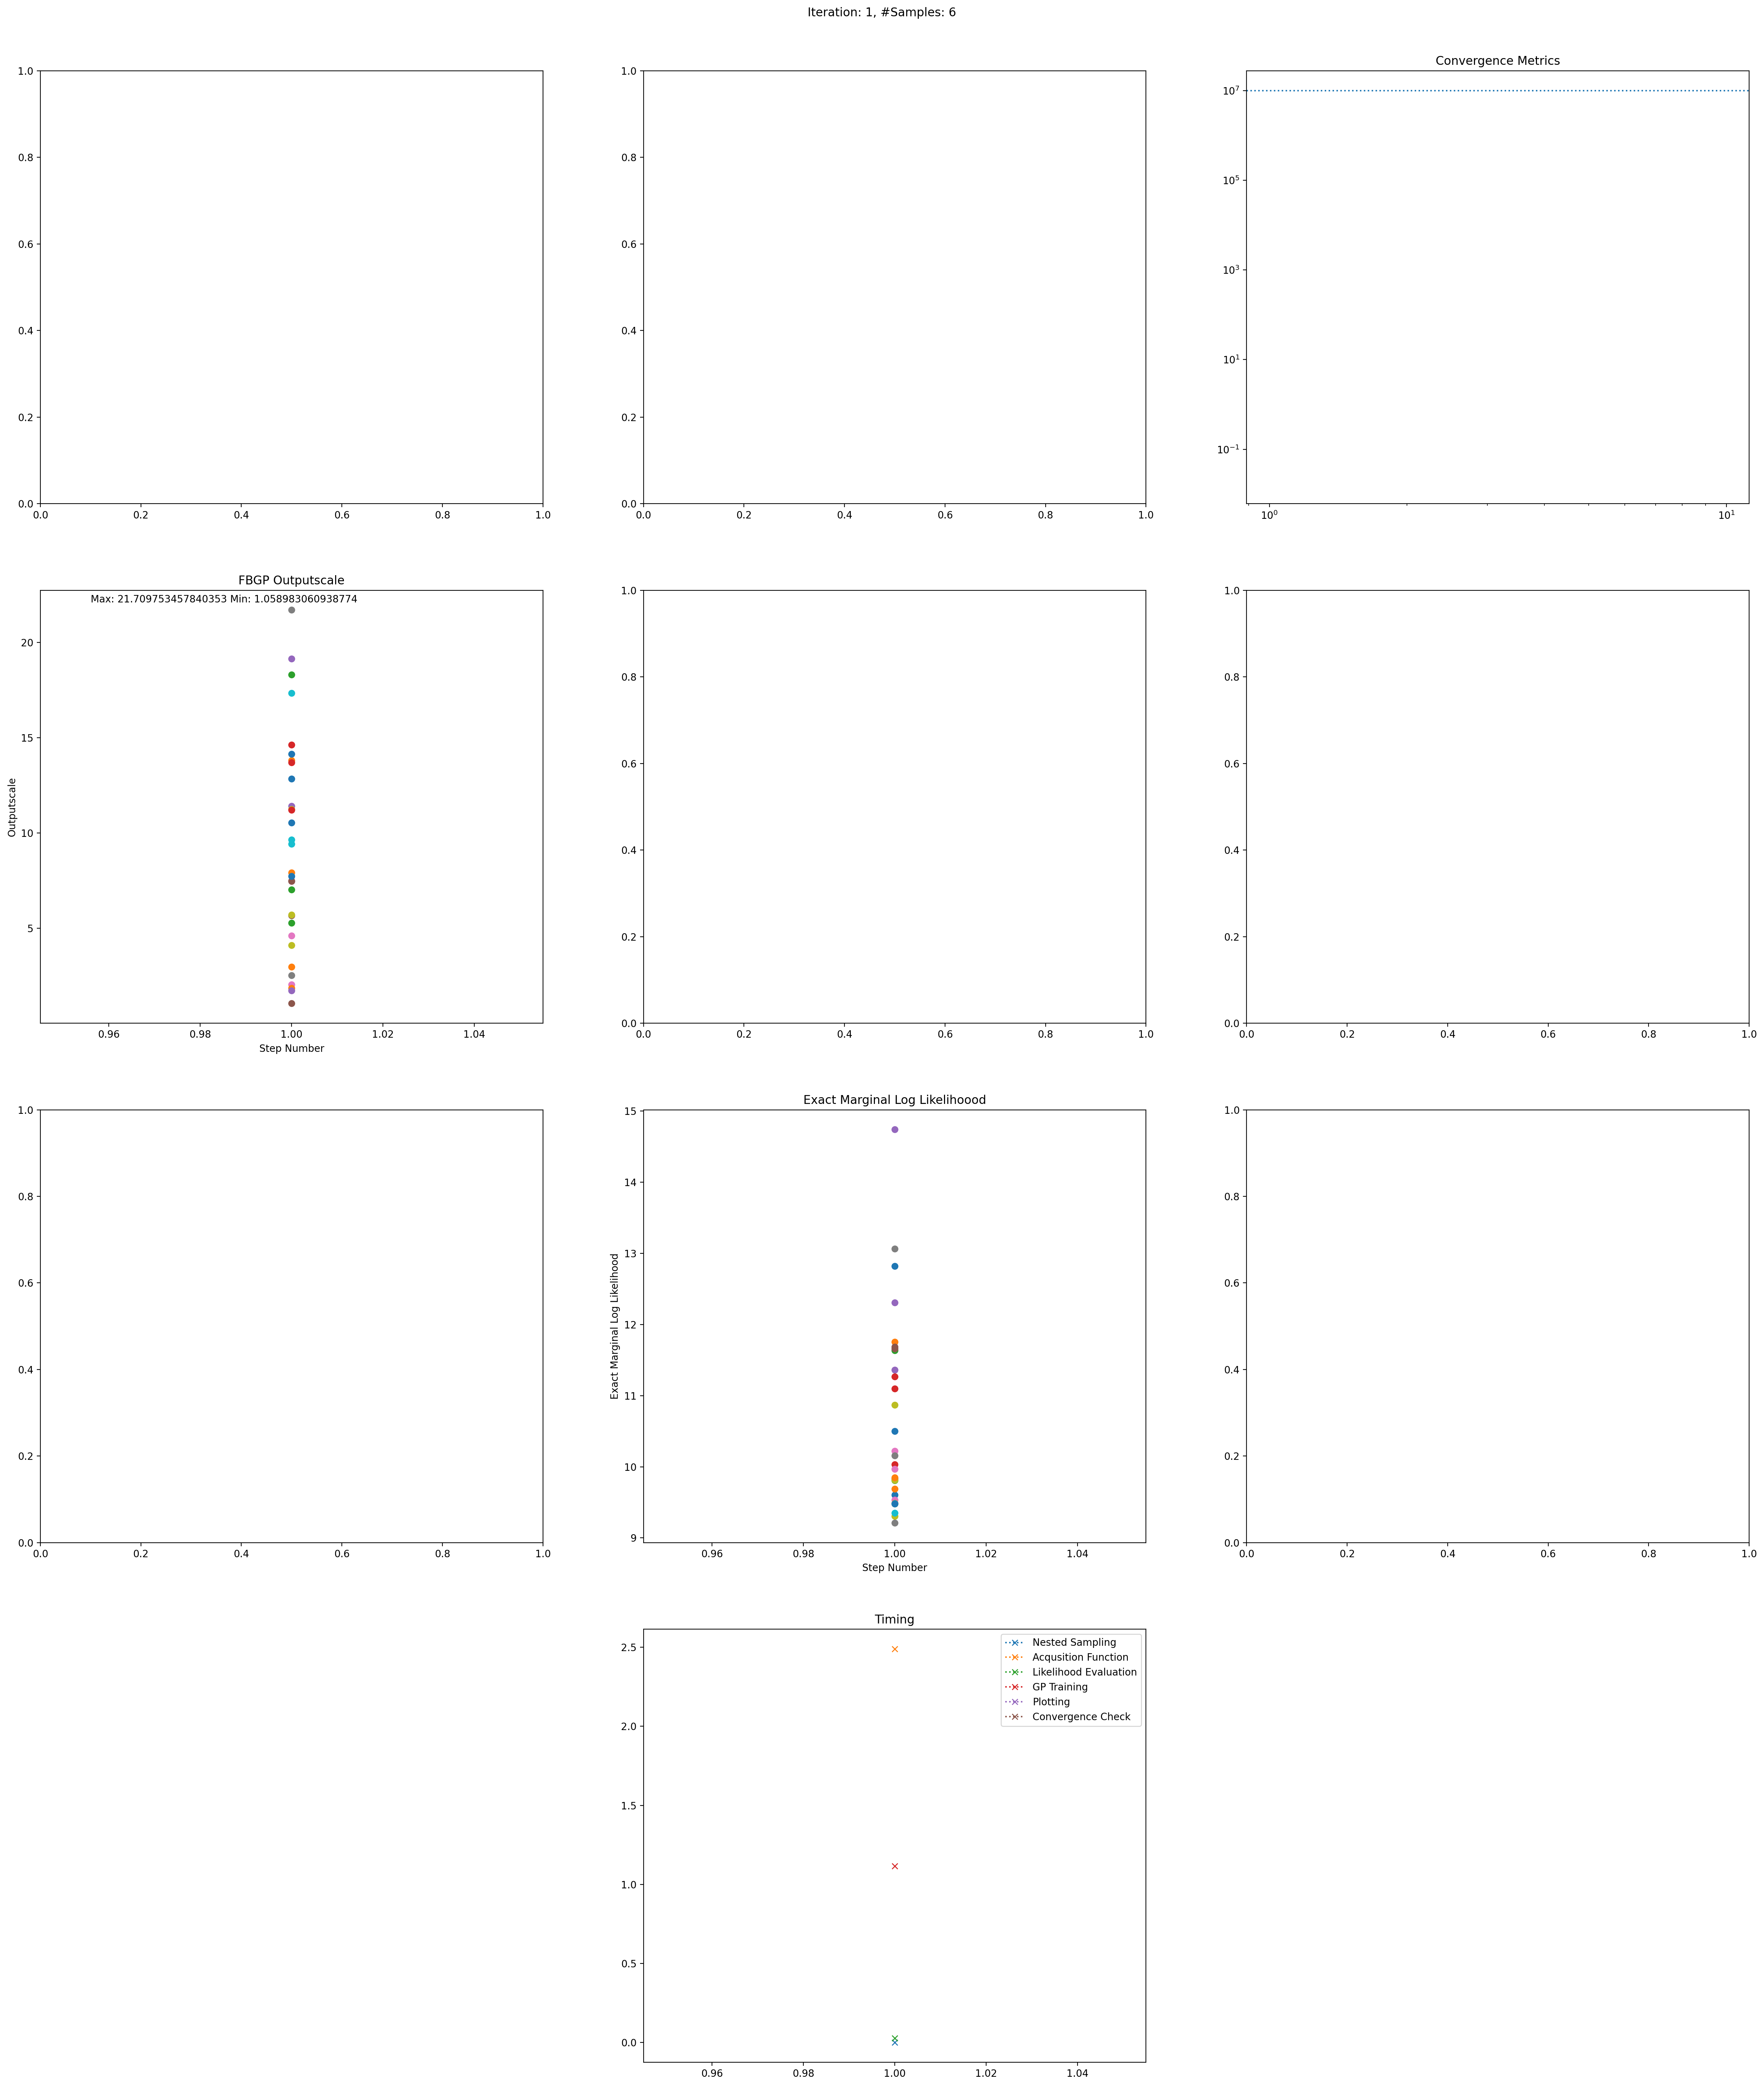

INFO:jaxns:Number of parallel Markov-chains set to: 500000


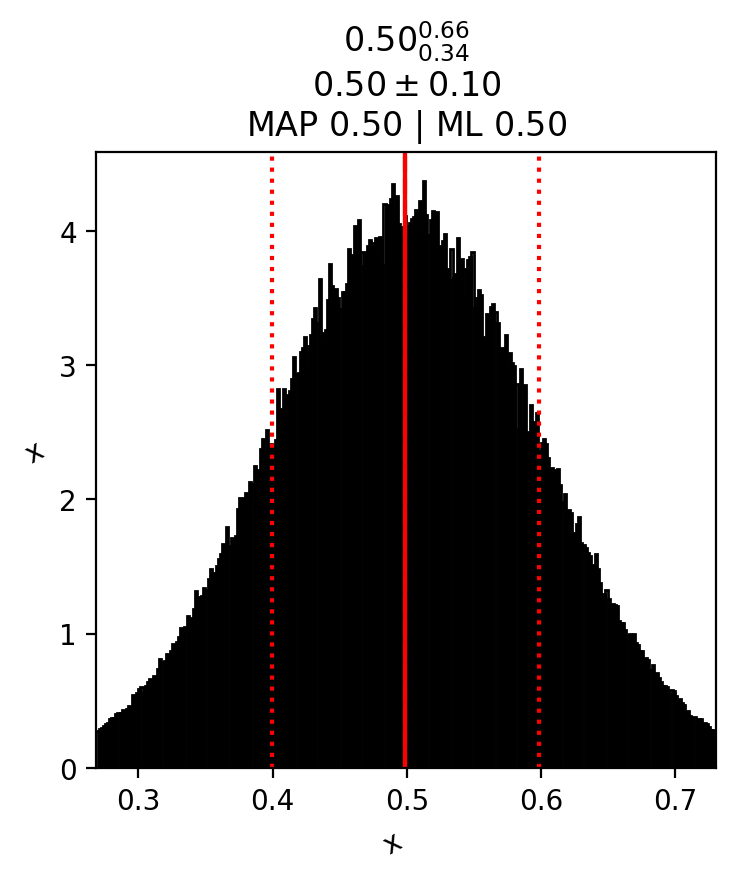

INFO:[NS]: Mean LogZ: -1.3851835534320558, Upper LogZ: -1.3362516236145046, Lower LogZ: -1.4340070197371562, Internal dLogZ: 0.00192014958918853
INFO:[NS]: Nested Sampling took 24.03s
INFO:[NS]:1
INFO:[NS]: jaxns did 500000 likelihood evaluations, terminated due to Reached max samples


Abs Difference of nested sampler to true integral:  0.0015376819650891882 < 10000000 +- 0.00192014958918853
Estimated precision on integral:  1.3713204418624076 < 10000000


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 977.10it/s, 1 steps of size 8.17e-01. acc. prob=0.93]


MCMC took 1.1928 s
2
Py-Bobyqa took 0.9343 s
New Points:  [[0.70128857]
 [0.14566478]]
Convergence Check:  0.0022932584943063244 
 Pre-Var:  0.002446573736986791 
 Post-Var:  0.00015331524268046687


sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 1294.06it/s, 7 steps of size 8.34e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 1.07s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]     10.60     11.85      5.45      0.26     31.21     43.41      0.99
        kernel_length[0]      0.50      0.10      0.49      0.38      0.62     28.04      0.99
            kernel_tausq      1.75      2.81      0.83      0.12      3.99     25.58      0.97
              kernel_var     20.46      9.84     17.70      5.14     32.05     46.22      0.97

Number of divergences: 0


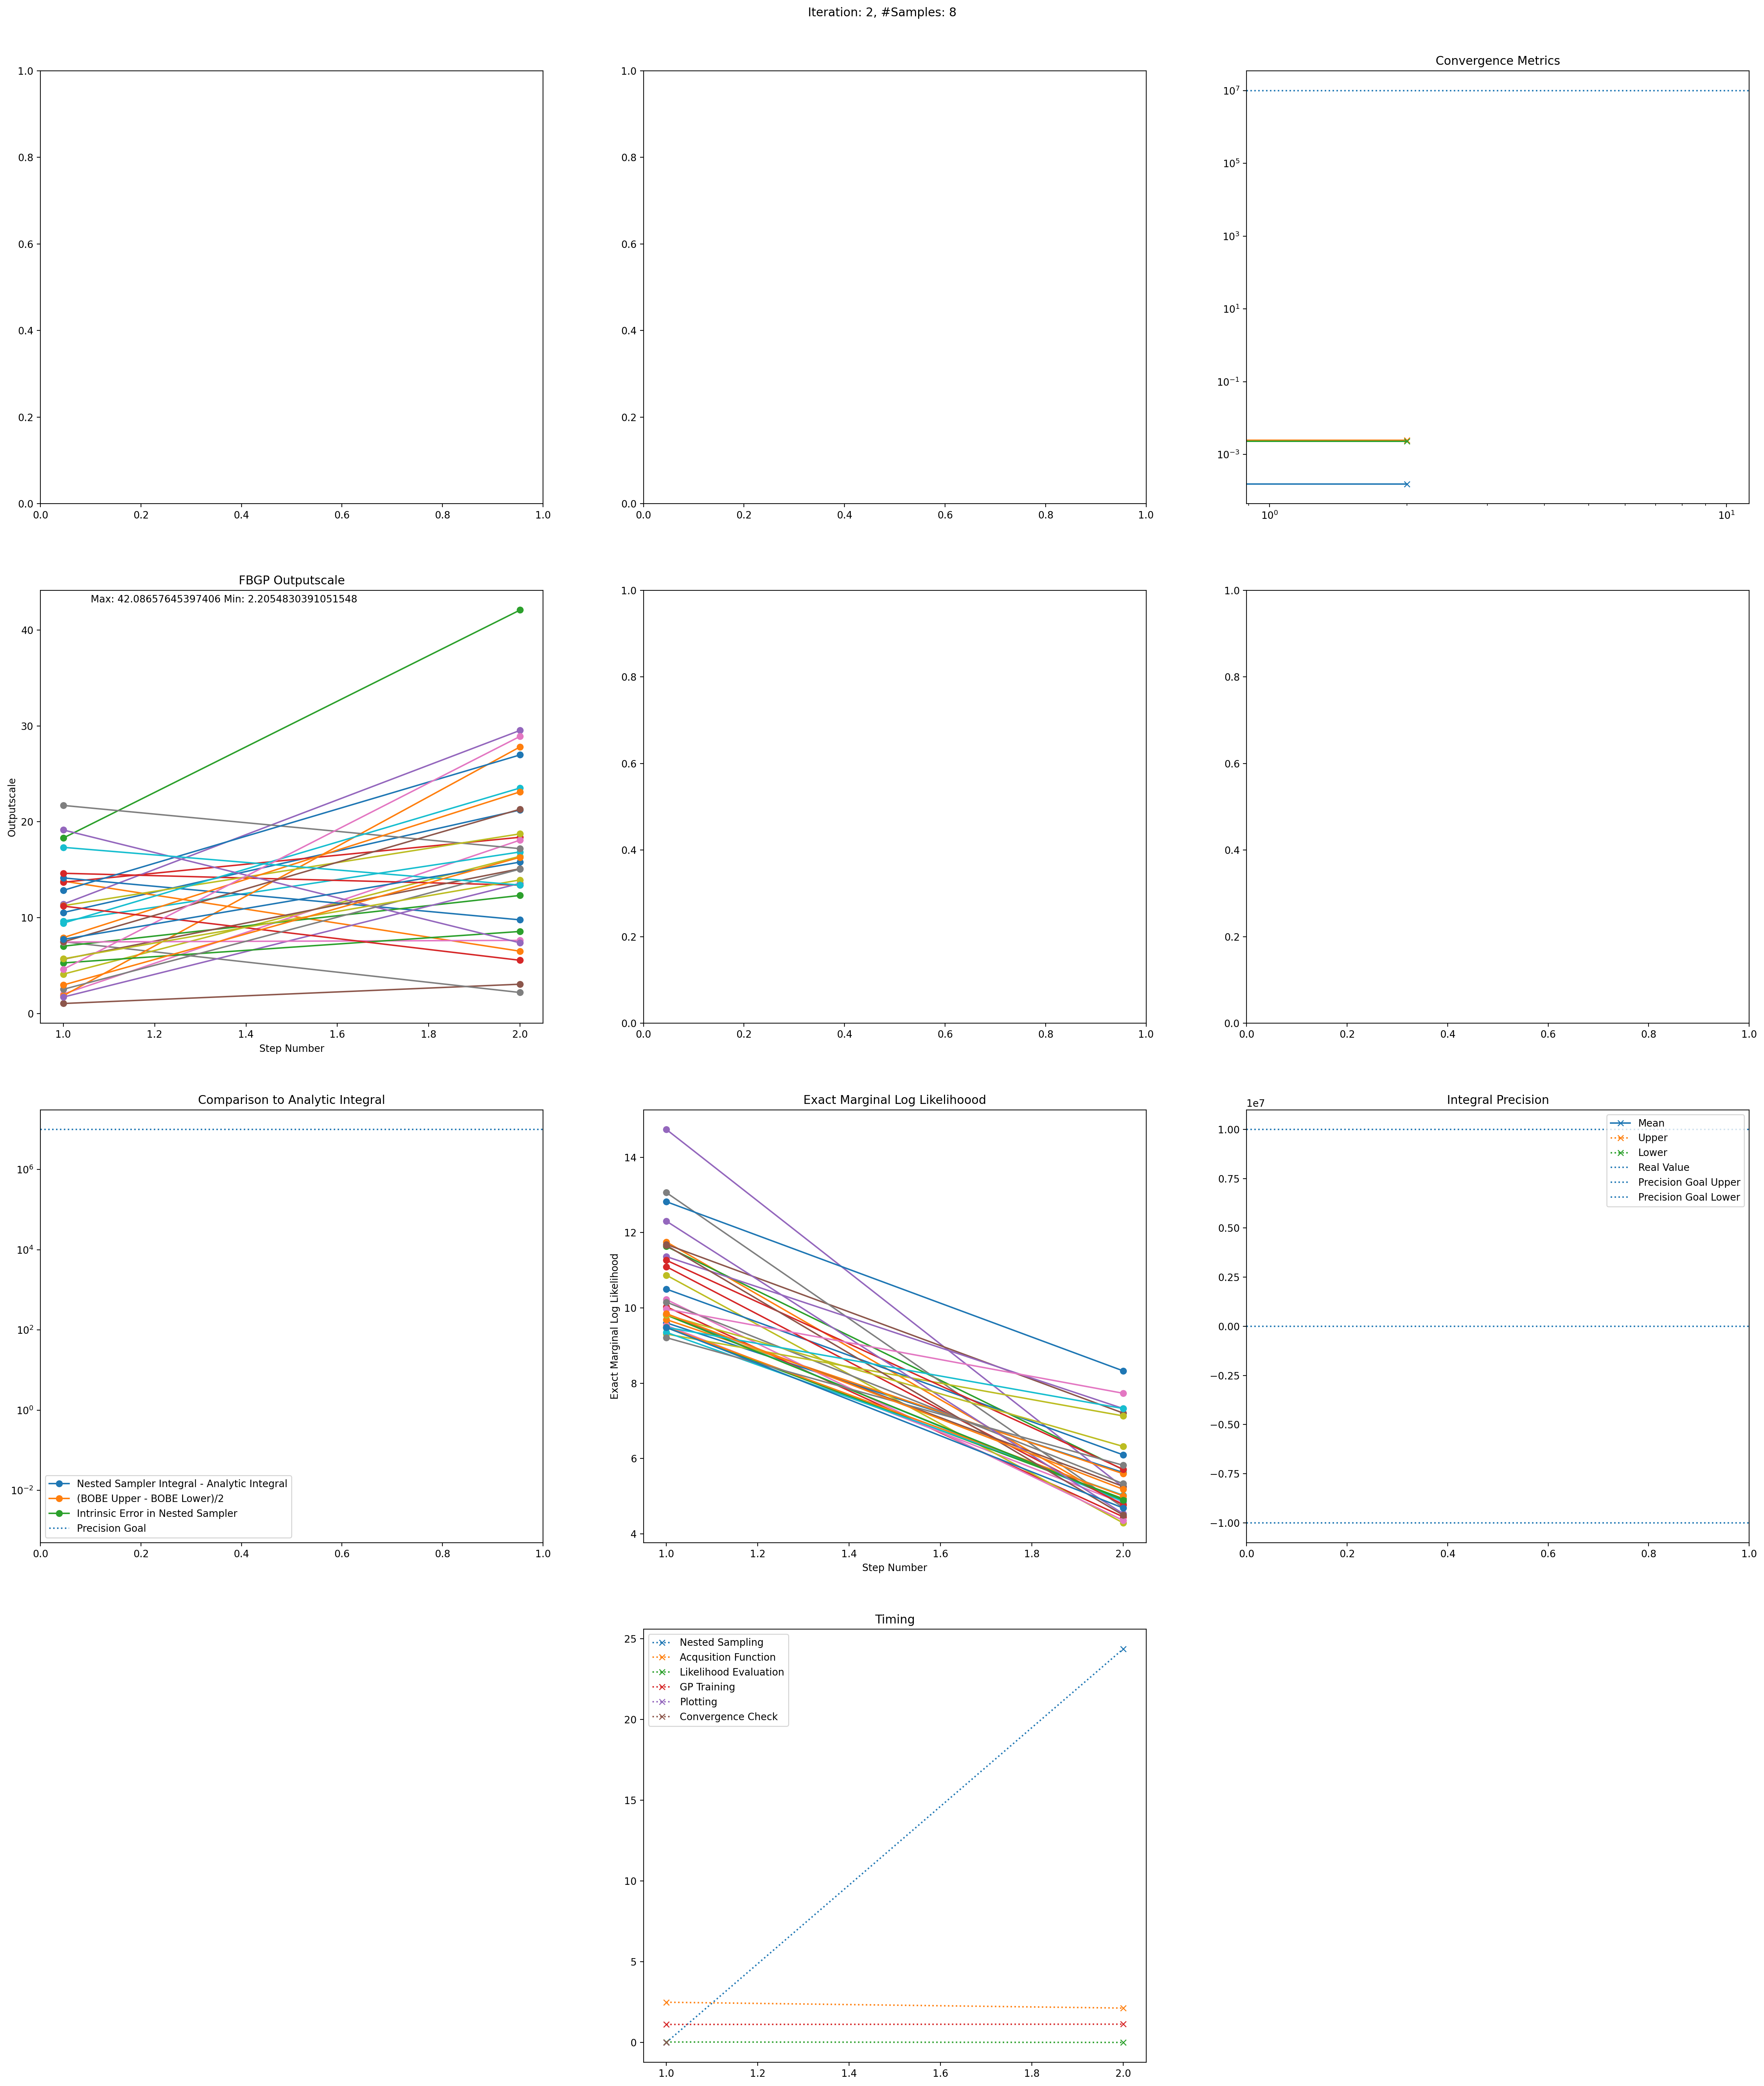

Converged
LogZ: -1.3851835534320558 ± 0.0488776980613258


In [8]:
### Start the main sampling loop ###
converged = False

curr_step = 1            

acq_check = 1

acq_check_converged = False

variance_debug = True
general_debug = True
slow_plot_flag = False

FBGP_outputscale = []
FBGP_lengthscales = []

computed_mlls = []
computed_mlls_acqgp = []

integral_true_accuracy = []

log_z_mean = []
log_z_upper = []
log_z_lower = []

post_var_plot = []
pre_var_plot = []
acq_check_plot = []

timing = {'Nested_Sampling': [],'Acq_Fnct': [], 'Acq_Check': [], 'Likelihood': [], 'GP_Train': [], 'Plot': [], 'Converge_Check': []}

while not converged:
    ### Get Hyperparemets for plotting ###
    lengthscales, outputscale = FBGP.get_map_hyperparams()
    FBGP_lengthscales.append(FBGP.samples["kernel_length"])
    FBGP_outputscale.append(FBGP.samples["kernel_var"])
    ######################################
    ### Get MC Samples for IPV and calculate logz [Timing: Nested_Sampling] ###
    start = time.time()
    if acq_check_converged and curr_step % nested_sample_every == 0: 
        if nested_sampler.lower() == 'dynesty':
            gp_samples , logz_dict = nested_sampling_Dy(
                                FBGP,
                                ndim,
                                dlogz = acq_goal*(1e-1))
        if nested_sampler.lower() == 'jax':
            samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(FBGP,
                                                                                 ndim=ndim,
                                                                                 dlogz=acq_goal*(1e-1))

        if logz_dict['dlogz sampler'] >= acq_goal:
            raise Exception("Dlogz from Nested Sampler too high")
        
        log_z_mean.append(logz_dict['mean'])
        log_z_upper.append(logz_dict['upper'])
        log_z_lower.append(logz_dict['lower'])

        abs_diff_true_ns = np.abs(log_z_mean[-1] + prior_fac - logz_truth) #Convert log(z_dy)/prior volume -> log(z)

        integral_true_accuracy.append([abs_diff_true_ns, acq_check, (log_z_upper[-1]-log_z_lower[-1])/2, logz_dict['dlogz sampler']])
        
        if general_debug:
            #print(logz_dict)
            print("Abs Difference of nested sampler to true integral: ", abs_diff_true_ns, "<" if abs_diff_true_ns < acq_goal else ">", acq_goal, "+-", logz_dict['dlogz sampler'])
            
        
    elif acq_check_converged and len(logz_dict) != 0:
        log_z_mean.append(logz_dict['mean'])
        log_z_upper.append(logz_dict['upper'])
        log_z_lower.append(logz_dict['lower'])
        
    end = time.time()
    timing['Nested_Sampling'].append(end-start)
    
    if general_debug:
        print("Estimated precision on integral: ", acq_check, "<" if acq_check < acq_goal else ">", acq_goal)
    
    #Convert mc samples into internally consistent units
    
    ##################################################
    ### Define and optimise Acquisition Function [Timing: Acq_Fnct]###
    start = time.time()
    if not acq_check_converged:
        #samples_unit = sample_GP_NUTS(FBGP, rng_key)
        log_z_mean.append(np.nan)
        log_z_upper.append(np.nan)
        log_z_lower.append(np.nan)
        integral_true_accuracy.append([np.nan, acq_check, np.nan, np.nan])
        
    rng_key, _ = random.split(random.PRNGKey(curr_step), 2)
    x0 = np.random.rand(batch_size,ndim) # can do better than random?
    x0 = x0.reshape(batch_size*ndim)
    x_new, post_var, WIPV = optimize_acq(rng_key=rng_key,
                                    gp=FBGP,
                                    x0=x0,
                                    ndim=ndim,
                                    step=curr_step,
                                    optimizer_kwargs={'batch_size': batch_size},
                                    acq_kwargs={'batch_size': batch_size})
    mc_points = WIPV.mc_points
    end = time.time()
    timing['Acq_Fnct'].append(end-start)
    ##################################################
    
    if general_debug:
        print("New Points: ", x_new)

    ### Calculate Pre/Post Var and evaluate Acq check [Timing: Acq_Check] ###
    start = time.time()
    pre_var = FBGP.posterior(mc_points)[1].mean()
    post_var = abs(post_var)
    acq_check = abs(pre_var-post_var)
    post_var_plot.append(post_var)
    pre_var_plot.append(pre_var)
    acq_check_plot.append(acq_check)
    if general_debug:
        print("Convergence Check: ", acq_check, "\n", "Pre-Var: ", pre_var, "\n", "Post-Var: ", post_var) #"FBGP Pre-Var: ", pre_var_FBGP,
    end = time.time()
    timing['Acq_Check'].append(end-start)
    ########################################################################

    
    #Evaluate likelihood at new point(s) [Timing: Likelihood] ###
    start = time.time()
    y_new = logp(x_new)
    end = time.time()
    timing['Likelihood'].append(end - start)
    #############################################################

    
    ### Train GPs on new data [Timing: GP_Train]###
    start = time.time()
    if curr_step % gp_train_every == 0:
        train_X = np.concatenate([train_X, np.atleast_2d(x_new)])
        train_Y = np.concatenate([train_Y, np.atleast_2d(y_new)])
        FBGP = saas_fbgp(train_X, train_Y, noise)
        FBGP.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)
        computed_mlls.append(FBGP.samples["minus_log_prob"])
    else:
        ### Add quick fit option ###
        print("Quick GP Fitting not implemented")
        
    end = time.time()
    timing['GP_Train'].append(end-start)
    #############################

    
    ### Plot prediction to ensure consistency [Timing: Plot]###
    start = time.time()
    '''if ndim == 2:
        x = np.linspace(start=0, stop=1, num=100)
        y = x
        xx, yy = np.meshgrid(x, y)
        X_plot = np.vstack([xx.ravel(), yy.ravel()]).T
        Y_plot = logp(torch.tensor(X_plot)) if BOTORCH_FLAG else logp(X_plot)
    if ndim == 1:
        X_plot = np.linspace(start=0, stop=1, num=100).reshape(-1, 1)
        Y_plot = logp(torch.tensor(X_plot))
    if ndim <= 2:
        mean_FB = FBGP.posterior(X_plot)[0].mean()
        std_FB = np.sqrt(FBGP.posterior(X_plot)[1].mean())
            
    if variance_debug and ndim <=2:
        print("FB Max STD: ", std_FB.max())
        print("FB Min STD: ", std_FB.min())
        print("FB STD at training points: ", np.sqrt(FBGP.posterior(train_X)[1].mean()))
    if ndim == 2:
        fig,ax = plt.subplots(5, 3, figsize=(25, 30))
        fig.delaxes(ax[4,0])
        fig.delaxes(ax[4,2])
        fig.suptitle(f"Iteration: {curr_step}, #Samples: {nstart+batch_size*curr_step}")
        ax = slice_plot_2d(ax, FBGP, train_X, train_Y, logp)
        ax = acq_check_metric_plot(ax, curr_step, acq_goal, post_var_plot, pre_var_plot, acq_check_plot, integral_true_accuracy)
        ax = FBGP_hyperparameter_plot(ax, curr_step, FBGP_outputscale, FBGP_lengthscales)
        ax = FBGP_mll_plot(ax, curr_step, computed_mlls)
        if acq_check_converged:
            ax = integral_accuracy_plot(ax, curr_step, acq_goal, log_z_mean, log_z_upper, log_z_lower, logz_truth, prior_fac)
            ax = integral_metrics_plot(ax, curr_step, integral_true_accuracy, acq_goal)
        ax = FBGP_prediction_plots(ax, FBGP, logp, train_X, train_Y, samples_unit, param_list, bounds_dict, nstart)
        ax = timing_plot(ax, curr_step, timing, ndim)
    if ndim > 2:'''
    fig,ax = plt.subplots(4, 3, figsize=(25, 30))
    fig.delaxes(ax[3,0])
    fig.delaxes(ax[3,2])
    fig.suptitle(f"Iteration: {curr_step}, #Samples: {nstart+batch_size*curr_step}")
    ax = acq_check_metric_plot(ax, curr_step, acq_goal, post_var_plot, pre_var_plot, acq_check_plot, integral_true_accuracy)
    ax = FBGP_hyperparameter_plot(ax, curr_step, FBGP_outputscale, FBGP_lengthscales)
    ax = FBGP_mll_plot(ax, curr_step, computed_mlls)
    if acq_check_converged:
        ax = integral_accuracy_plot(ax, curr_step, acq_goal, log_z_mean, log_z_upper, log_z_lower, logz_truth, prior_fac)
        ax = integral_metrics_plot(ax, curr_step, integral_true_accuracy, acq_goal)
    ax = timing_plot(ax, curr_step, timing, ndim)
    
    plt.tight_layout()
    
    plt.subplots_adjust(
                top=0.95,
                wspace=0.2, 
                hspace=0.2)
    if save_plot:
        fig.savefig(f"GIFs/{ndim}D/{loglike.__qualname__}_step_{curr_step}.png")
    if show_plot:
        plt.show()
    timing['Plot'].append(end-start)
    ##################################################
    ### Convergence Check [Timing: Converge_Check] ###
    start = time.time()
    #Decide if converged or not
    if acq_check <= acq_goal:
        acq_check_converged = True
        if np.array(integral_true_accuracy)[:, 2][-1] <= acq_goal:
            print("Converged")
            #print(f"LogZ: {np.exp(log_z_mean[-1])} ± {np.exp(log_z_mean[-1])*np.array(integral_true_accuracy)[:, 2][-1]}")
            print(f"LogZ: {log_z_mean[-1]} ± {np.array(integral_true_accuracy)[:, 2][-1]}")
            converged = True
            if save_plot:
                png2gif(curr_step, loglike.__qualname__, ndim)
    if curr_step > max_steps:
        print("Reached Max Steps")
        converged = True
        if save_plot:
            png2gif(curr_step, loglike.__qualname__, ndim)
        
    curr_step += 1
    end = time.time()
    timing['Converge_Check'].append(end - start)
    ########################

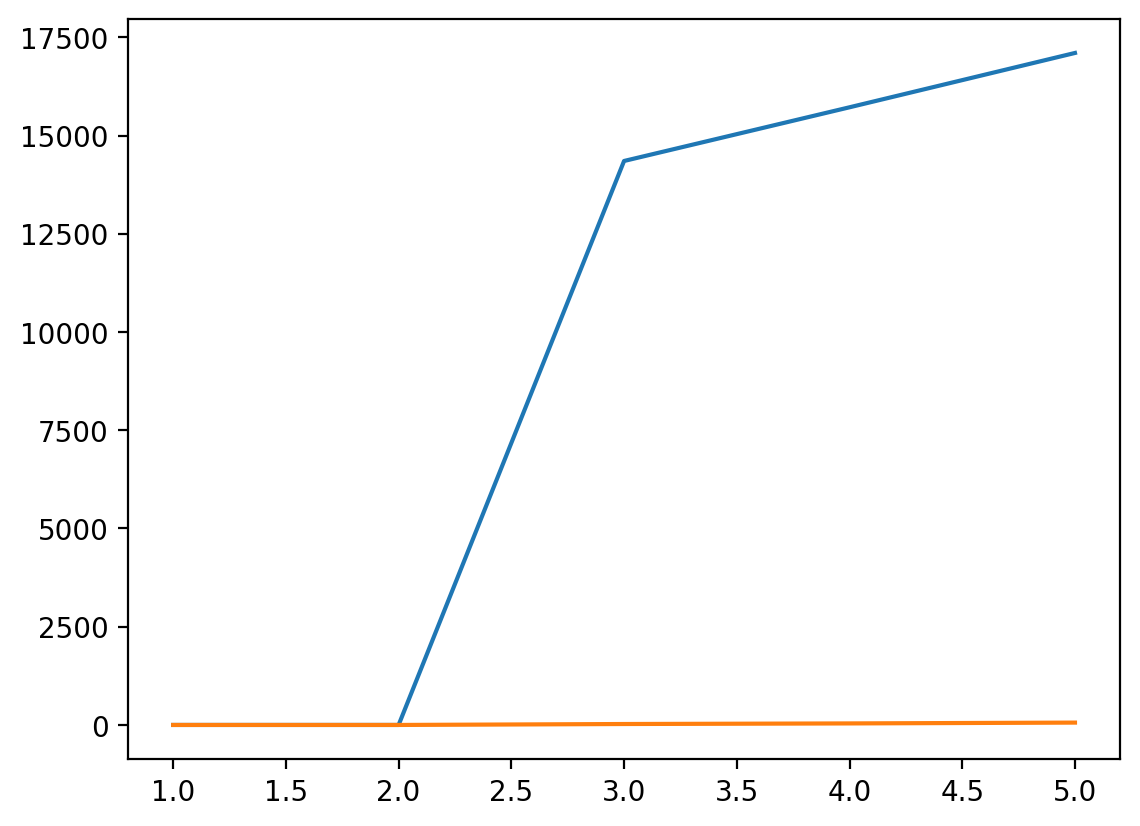

In [9]:
#Samples vs Dimensions
x = [1, 2, 3, 4, 5]
y_dyn = [-1, -1, 14354.33, 15721, 17104]
y_bobe = [-1, -1, 23, 38, 59]

plt.figure()
plt.plot(x, y_dyn)
plt.plot(x, y_bobe)
plt.show()

In [10]:
15721, 38

(15721, 38)